In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark").getOrCreate()
# spark

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

def shape(df):
    print((df.count(), len(df.columns)))

# Load data
**dataset from RFM with PySpark**

In [5]:
rfm_numbers = spark.read.csv("customer_rfm_numbers.csv", 
                             inferSchema=True, 
                             header=True)
printdf(rfm_numbers)

,CustomerID,Recency,Frequency,Monetary
0,15619,11,1,337.0
1,17389,1,34,31852.0
2,14450,181,3,485.0
3,15727,17,7,5220.0
4,15790,11,1,225.0


<!-- # Prepare data -->

# Inspect

In [6]:
df_rfm_numbers = rfm_numbers.toPandas()
df_rfm_numbers.describe()

,CustomerID,Recency,Frequency,Monetary
count,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,92.722265,4.246111,1870.640653
std,1576.823683,99.528532,7.205750,7485.207270
min,12346.000000,1.000000,1.000000,0.000000
25%,14208.000000,18.000000,1.000000,301.000000
50%,15569.000000,51.000000,2.000000,654.000000
75%,16913.000000,143.000000,5.000000,1587.000000
max,18287.000000,374.000000,210.000000,259665.000000


<AxesSubplot:xlabel='Monetary', ylabel='Count'>

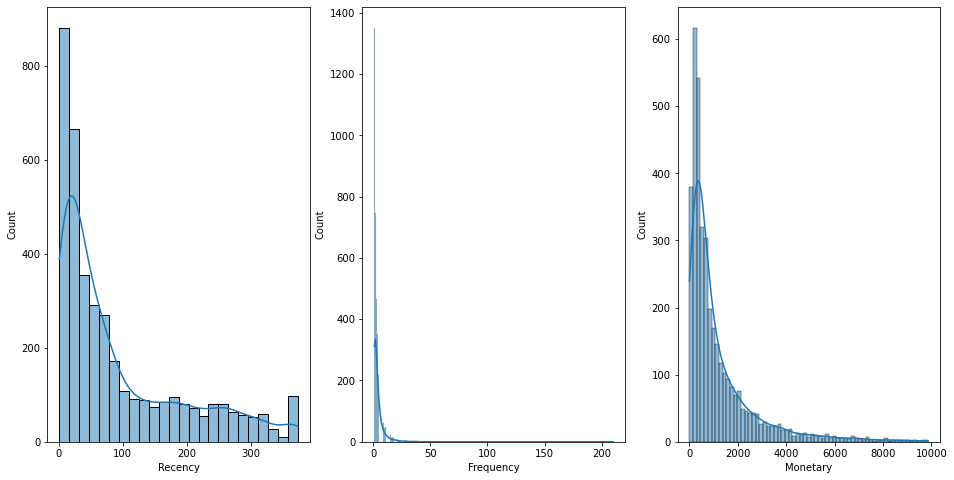

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(df_rfm_numbers['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(df_rfm_numbers.query('Frequency < 1000')['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(df_rfm_numbers.query('Monetary < 10000')['Monetary'], kde=True, ax=ax[2])

# K-Means Clustering

In [8]:
# Since log transformation doesn't work with negative and zero values, lets get rid of negative and zeros

rfm_data = (
    rfm_numbers.withColumn(
        "Monetary", 
        F.when(F.col("Monetary") <= 0, 1)
         .otherwise(F.col("Monetary")))
)

# rfm_data = rfm_numbers
# printdf(rfm_data)

# Elbow Analysis

In [9]:
features = rfm_data.columns[1:]

printdf(rfm_data)

,CustomerID,Recency,Frequency,Monetary
0,15619,11,1,337.0
1,17389,1,34,31852.0
2,14450,181,3,485.0
3,15727,17,7,5220.0
4,15790,11,1,225.0


In [10]:
assembler = VectorAssembler(
    inputCols=features, 
    outputCol="rfm_features")

assembled_data = assembler.transform(rfm_data)

assembled_data = assembled_data.select('CustomerID', 'rfm_features')

printdf(assembled_data)

,CustomerID,rfm_features
0,15619,"[11.0, 1.0, 337.0]"
1,17389,"[1.0, 34.0, 31852.0]"
2,14450,"[181.0, 3.0, 485.0]"
3,15727,"[17.0, 7.0, 5220.0]"
4,15790,"[11.0, 1.0, 225.0]"


In [11]:
scaler = StandardScaler(inputCol='rfm_features', outputCol='rfm_standardized')

data_scale = scaler.fit(assembled_data)

scaled_data = data_scale.transform(assembled_data)

printdf(scaled_data)

,CustomerID,rfm_features,rfm_standardized
0,15619,"[11.0, 1.0, 337.0]","[0.11052107132513378, 0.13877806001284734, 0.0..."
1,17389,"[1.0, 34.0, 31852.0]","[0.010047370120466708, 4.71845404043681, 4.255..."
2,14450,"[181.0, 3.0, 485.0]","[1.818573991804474, 0.41633418003854206, 0.064..."
3,15727,"[17.0, 7.0, 5220.0]","[0.17080529204793404, 0.9714464200899314, 0.69..."
4,15790,"[11.0, 1.0, 225.0]","[0.11052107132513378, 0.13877806001284734, 0.0..."


In [12]:
# working with `scaled_data`

costs = {}

for k in range(2, 10):
    k_means = KMeans(featuresCol='rfm_standardized', k=k)
    model = k_means.fit(scaled_data)
    costs[k] = model.computeCost(scaled_data)

Text(0, 0.5, 'cost')

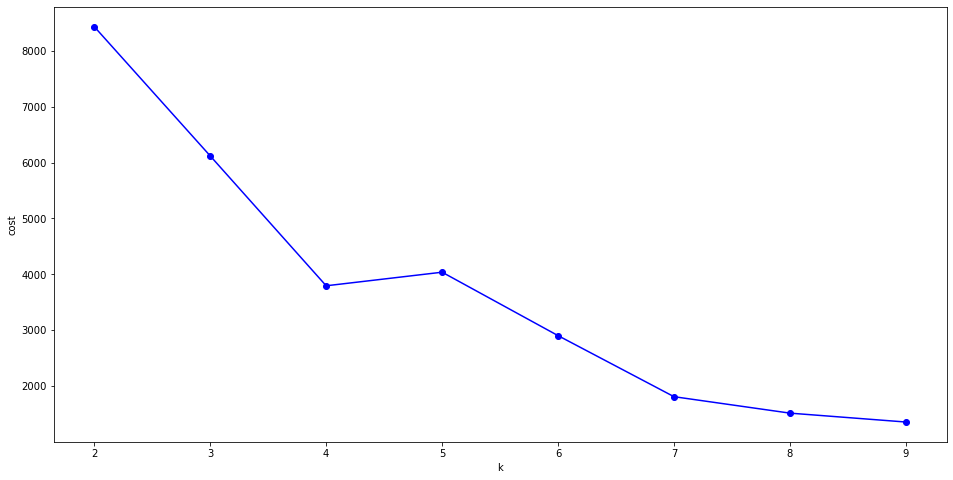

In [13]:
fig, ax = plt.subplots(1, 1, figsize =(16, 8))

ax.plot(costs.keys(), costs.values(), '-ob')
ax.set_xlabel('k')
ax.set_ylabel('cost')

# ax.plot(3, costs[3], 'bo')

# K = 4

In [14]:
k_means = KMeans(featuresCol='rfm_standardized', k=4)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

In [15]:
result = predictions.select('CustomerID', 'prediction')
printdf(result)

,CustomerID,prediction
0,15619,0
1,17389,3
2,14450,1
3,15727,0
4,15790,0


In [16]:
# Join other information with the prediction result-set

rfm_score = spark.read.csv('retail_loyalty_rfm.csv', 
                           inferSchema=True, 
                           header=True)
rfm_score = rfm_score.select("CustomerID", "Recency", "Frequency", "Monetary", "RFM_Score", "RFM_ScoreGroup", "Loyalty")
# printdf(rfm_score)

In [17]:
combined_result = result.join(rfm_score, on='CustomerID', how='inner')
printdf(combined_result)

,CustomerID,prediction,Recency,Frequency,Monetary,RFM_Score,RFM_ScoreGroup,Loyalty
0,16678,0,3,163,3111.0,3,111,Platinum
1,17735,0,3,690,13207.0,3,111,Platinum
2,17139,0,16,478,10750.0,3,111,Platinum
3,13408,3,2,478,28127.0,3,111,Platinum
4,17389,3,1,213,31852.0,3,111,Platinum


In [18]:
combined_result_df = combined_result.toPandas()

combined_result_df.to_csv('combined_result_k4.csv', index=False)

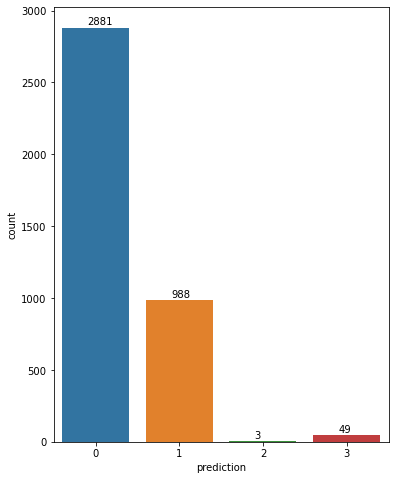

In [19]:
# inspect our loyalty segmentation

# combined_result_df = combined_result_df.sort_values("RFM_Score")

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=combined_result_df)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

# Observation

<AxesSubplot:xlabel='prediction', ylabel='Monetary'>

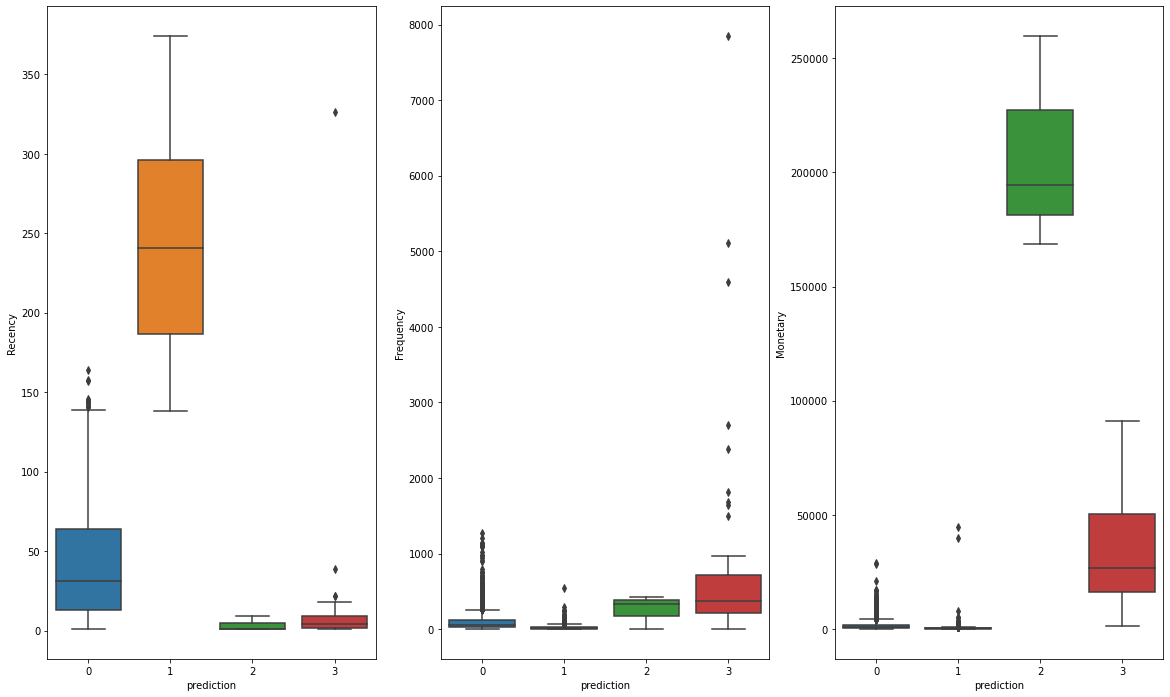

In [20]:
analysis_df = combined_result.toPandas()

fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='Recency', data=analysis_df, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=analysis_df, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=analysis_df, ax=ax[2])

# Visualization

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

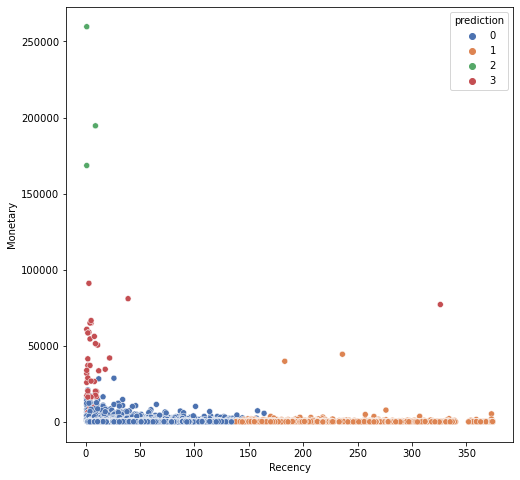

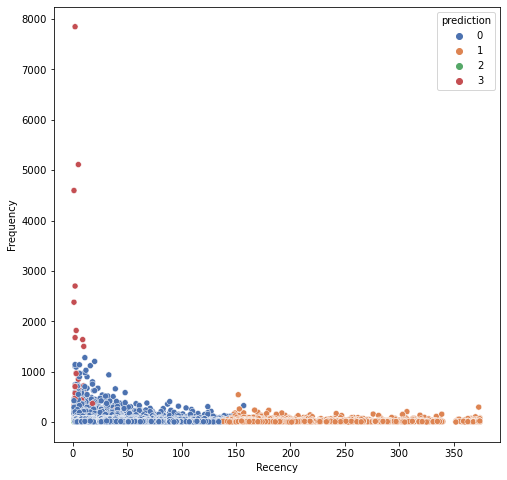

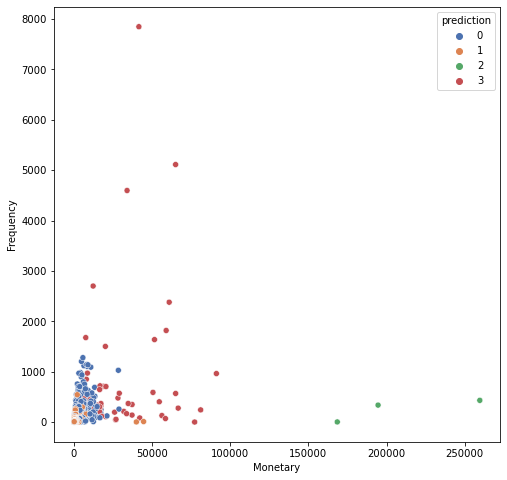

In [21]:
selected_result_df = combined_result_df#.query('Monetary < 100000').query('Frequency < 3000')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

In [22]:
analysis = combined_result\
    .groupBy('prediction')\
    .agg(F.avg('Recency').alias('Avg Recency'),
         F.avg('Frequency').alias('Avg Frequency'),
         F.avg('Monetary').alias('Avg Monetary'))
printdf(analysis)

,prediction,Avg Recency,Avg Frequency,Avg Monetary
0,1,245.197368,28.709514,528.567814
1,3,12.693878,892.000000,32142.081633
2,2,3.666667,257.000000,207567.333333
3,0,41.886845,97.709476,1601.837209
